# データ分析

In [ ]:
import sqlite3
import pandas as pd

conn_hotels = sqlite3.connect('accommodations.db')
df_hotels = pd.read_sql_query("SELECT * FROM hotels", conn_hotels)
conn_hotels.close()

conn_attractions = sqlite3.connect('attraction.db')
df_attractions = pd.read_sql_query("SELECT * FROM attractions", conn_attractions)
conn_attractions.close()

print("【宿泊施設データ (hotels) の先頭5件】")
print(df_hotels.head())

print("\n【観光地データ (attractions) の先頭5件】")
print(df_attractions.head())

print("\n--- データの件数 ---")
print(f"宿泊施設: {len(df_hotels)} 件")
print(f"観光地  : {len(df_attractions)} 件")

【宿泊施設データ (hotels) の先頭5件】
       id                  name        lat         lon  rating  review_count  \
0   89505      熱海温泉　熱海ニューフジヤホテル  35.097276  139.072448    3.77           122   
1    1969  グランドメルキュール浜名湖リゾート＆スパ  34.706965  137.615451    4.00           161   
2   65210        絶景の癒しの湯宿　茄子のはな  34.898561  139.095634    3.21             8   
3   90330        熱海温泉　伊東園ホテル熱海館  35.102019  139.076509    3.85           133   
4  348826             亀の井ホテル　熱海  35.092340  139.063659    3.44            33   

   price  
0   8401  
1   4591  
2   8250  
3   6798  
4  15200  

【観光地データ (attractions) の先頭5件】
        id   name          category        lat         lon
0  3438399  葉山御用邸            castle  35.261328  139.578173
1  4159594   東山聖苑  place_of_worship  35.700996  138.694141
2  7397603   江島神社  place_of_worship  35.299913  139.478140
3  8134918    鳳勝寺  place_of_worship  35.446482  139.400053
4  8200233  日本民家園            museum  35.609347  139.559627

--- データの件数 ---
宿泊施設: 300 件
観光地  : 5780 件


In [16]:
df_attractions

,id,name,category,lat,lon
0,3438399,葉山御用邸,castle,35.261328,139.578173
1,4159594,東山聖苑,place_of_worship,35.700996,138.694141
2,7397603,江島神社,place_of_worship,35.299913,139.478140
3,8134918,鳳勝寺,place_of_worship,35.446482,139.400053
4,8200233,日本民家園,museum,35.609347,139.559627
...,...,...,...,...,...
5775,13456209280,東圓寺,place_of_worship,35.387158,139.329711
5776,13456209281,廣済寺,place_of_worship,35.384414,139.323547
5777,13456209282,隆安寺,place_of_worship,35.384647,139.323018
5778,13472569097,大塚丘,place_of_worship,35.468990,138.789296


In [ ]:
print(df_attractions['category'].value_counts())

category
place_of_worship                            4091
attraction                                   589
museum                                       503
viewpoint                                    310
monument                                      94
ruins                                         58
castle                                        44
zoo                                           34
theme_park                                    34
aquarium                                      17
heritage                                       2
artwork                                        2
picnic_site;viewpoint                          1
QUEEN & JACK TOWERS YOKOHAMA VIEW POINT"       1
Name: count, dtype: int64


In [ ]:
noise_keywords = ['新幹線', '車窓', '中央構造線', '分岐', '交差点']

df_clean_attractions = df_attractions[
    ~df_attractions['name'].str.contains('|'.join(noise_keywords), na=False)
].copy()

print(f"清掃前: {len(df_attractions)} 件")
print(f"清掃後: {len(df_clean_attractions)} 件")

清掃前: 5780 件
清掃後: 5777 件


In [37]:
import pandas as pd
import folium
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # 地球の半径(km)
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

target_hotel = df_hotels.iloc[183] 
hotel_lat, hotel_lon = target_hotel['lat'], target_hotel['lon']
radius_km = 1.0 

df_attractions['dist'] = df_attractions.apply(
    lambda row: haversine(hotel_lon, hotel_lat, row['lon'], row['lat']), axis=1
)
nearby_attractions = df_attractions[df_attractions['dist'] <= radius_km]

print(f"--- {target_hotel['name']} 周辺の調査 ---")
print(f"半径 {radius_km}km 以内の観光地数: {len(nearby_attractions)} 件")
print(nearby_attractions[['name', 'category', 'dist']].sort_values('dist'))

m = folium.Map(location=[hotel_lat, hotel_lon], zoom_start=15)

folium.Marker(
    [hotel_lat, hotel_lon],
    popup=f"HOTEL: {target_hotel['name']}\nRating: {target_hotel['rating']}",
    icon=folium.Icon(color='red', icon='home')
).add_to(m)

folium.Circle(
    radius=radius_km * 1000, # メートル単位
    location=[hotel_lat, hotel_lon],
    color='crimson',
    fill=True,
)

for _, row in nearby_attractions.iterrows():
    folium.Marker(
        [row['lat'], row['lon']],
        popup=f"{row['name']} ({row['category']})",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

m.save('atami_test_map.html')
print("\n'atami_test_map.html' に地図を保存しました。ブラウザで開いて確認してください。")

--- ホテルメトロポリタン鎌倉 周辺の調査 ---
半径 1.0km 以内の観光地数: 59 件
                         name          category      dist
128                   鎌倉雪之下教会  place_of_worship  0.064632
156                       大巧寺  place_of_worship  0.076417
1513                    お稲荷さん  place_of_worship  0.133101
2675                   吉兆庵美術館            museum  0.150230
598                      蛭子神社  place_of_worship  0.179434
3054                    宇都宮稲荷  place_of_worship  0.192238
910                      小町通り        attraction  0.192861
3187               カトリック雪ノ下教会  place_of_worship  0.195604
3171                      妙隆寺  place_of_worship  0.296141
1687                鎌倉聖ミカエル教会  place_of_worship  0.351097
1695                      教恩寺  place_of_worship  0.364620
1688                      巽神社  place_of_worship  0.374718
142                常栄寺(ぼたもち寺)  place_of_worship  0.406336
869                 鏑木清方記念美術館            museum  0.433449
1680                      BAM            museum  0.446117
3070                  

In [ ]:
import pandas as pd
import sqlite3
import numpy as np

def fast_haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df_h = df_hotels.copy()
df_a = df_attractions.copy()

results = []

for _, hotel in df_h.iterrows():

    distances = fast_haversine(hotel['lat'], hotel['lon'], df_a['lat'], df_a['lon'])
    
    nearby = df_a[distances <= 1.0]
    
    res = {
        'id': hotel['id'],
        'name': hotel['name'],
        'rating': hotel['rating'],
        'review_count': hotel['review_count'],
        'price': hotel['price'],
        'total_count': len(nearby),
        'museum_count': len(nearby[nearby['category'] == 'museum']),
        'shrine_temple_count': len(nearby[nearby['category'] == 'place_of_worship']),
        'viewpoint_count': len(nearby[nearby['category'] == 'viewpoint']),
        'theme_park_count': len(nearby[nearby['category'] == 'theme_park'])
    }
    results.append(res)

df_analysis = pd.DataFrame(results)

--- 相関係数（Ratingとの関係） ---
rating                 1.000000
museum_count           0.147111
price                  0.030689
total_count           -0.012975
shrine_temple_count   -0.080853
Name: rating, dtype: float64


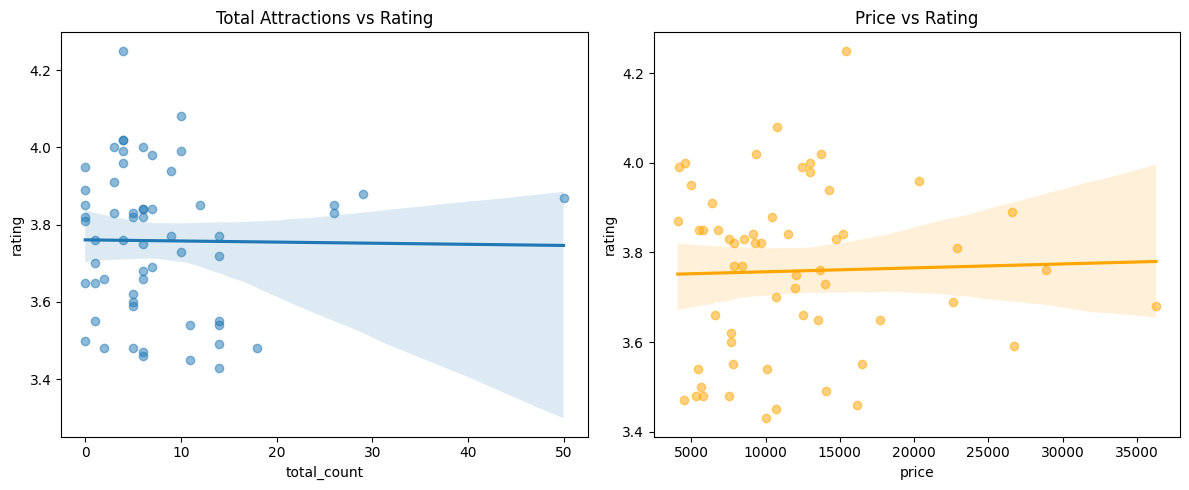

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_filtered = df_analysis[df_analysis['review_count'] >= 50].copy()

correlation_matrix = df_filtered[['rating', 'total_count', 'museum_count', 'shrine_temple_count', 'price']].corr()

print("--- 相関係数（Ratingとの関係） ---")
print(correlation_matrix['rating'].sort_values(ascending=False))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.regplot(data=df_filtered, x='total_count', y='rating', scatter_kws={'alpha':0.5})
plt.title('Total Attractions vs Rating')

plt.subplot(1, 2, 2)
sns.regplot(data=df_filtered, x='price', y='rating', color='orange', scatter_kws={'alpha':0.5})
plt.title('Price vs Rating')

plt.tight_layout()
plt.show()

In [35]:
top5_total = df_analysis.nlargest(5, 'total_count')[['name', 'total_count', 'rating', 'price']]

top5_museum = df_analysis.nlargest(5, 'museum_count')[['name', 'museum_count', 'rating']]

top5_shrine = df_analysis.nlargest(5, 'shrine_temple_count')[['name', 'shrine_temple_count', 'rating']]

top5_viewpoint = df_analysis.nlargest(5, 'viewpoint_count')[['name', 'viewpoint_count', 'rating']]

print("【全体：周辺観光地数 BEST5】")
print(top5_total)
print("\n【カテゴリー別：美術館 BEST5】")
print(top5_museum)
print("\n【カテゴリー別：神社仏閣 BEST5】")
print(top5_shrine)
print("\n【カテゴリー別：展望スポット BEST5】")
print(top5_viewpoint)  

【全体：周辺観光地数 BEST5】
               name  total_count  rating  price
183    ホテルメトロポリタン鎌倉           59    3.48   8794
47   浜名湖かんざんじ温泉　嵐の館           55    3.13   3467
152   ホテルルートイン横浜馬車道           50    3.87   4076
150     天成園　小田原駅　別館           43    3.40   8500
192    トーセイホテルココネ鎌倉           42    3.26   7415

【カテゴリー別：美術館 BEST5】
                   name  museum_count  rating
152       ホテルルートイン横浜馬車道            15    3.87
183        ホテルメトロポリタン鎌倉            11    3.48
178      横浜みなとみらい　万葉倶楽部            10    3.88
192        トーセイホテルココネ鎌倉             7    3.26
57   ホテル＆スパ　アンダリゾート伊豆高原             5    3.83

【カテゴリー別：神社仏閣 BEST5】
                    name  shrine_temple_count  rating
183         ホテルメトロポリタン鎌倉                   45    3.48
150          天成園　小田原駅　別館                   36    3.40
192         トーセイホテルココネ鎌倉                   32    3.26
283  天然温泉　甲斐路の湯　ドーミーイン甲府                   21    3.85
266              城のホテル甲府                   20    3.83

【カテゴリー別：展望スポット BEST5】
                          name